In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import geopandas
import numpy as np
import sqlalchemy as sa
import re
import dateutil
import pudl
import pathlib
import zipfile

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
%matplotlib inline

In [14]:
#plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (20,8)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [15]:
import logging
import sys
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
log_format = '%(asctime)s [%(levelname)8s] %(name)s:%(lineno)s %(message)s'
formatter = logging.Formatter(log_format)
handler.setFormatter(formatter)
logger.handlers = [handler]

In [16]:
pudl_settings = pudl.workspace.setup.derive_paths(pudl_in="/home/zane/code/catalyst/pudl-work", pudl_out="/home/zane/code/catalyst/pudl-work")
ferc1_engine = sa.create_engine(pudl_settings['ferc1_db'])
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_settings

{'pudl_in': '/home/zane/code/catalyst/pudl-work',
 'data_dir': '/home/zane/code/catalyst/pudl-work/data',
 'settings_dir': '/home/zane/code/catalyst/pudl-work/settings',
 'pudl_out': '/home/zane/code/catalyst/pudl-work',
 'sqlite_dir': '/home/zane/code/catalyst/pudl-work/sqlite',
 'parquet_dir': '/home/zane/code/catalyst/pudl-work/parquet',
 'datapkg_dir': '/home/zane/code/catalyst/pudl-work/datapkg',
 'notebook_dir': '/home/zane/code/catalyst/pudl-work/notebook',
 'ferc1_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/ferc1.sqlite',
 'pudl_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/pudl.sqlite'}

# Remaining Tasks

## Historical Geometries

### Characterizing Unmapped Demand:
* Calculate fraction of mapped vs. unmapped demand per year based on 2018 HIFLD geometries
  * In 2018 as reported it's 88%
  * By 2006 it's dropped to 58% 
* After hand assigning PacifiCorp and a couple of small co-ops their EIA utility IDs, the remaining respondents which lack `eia_code` values have no demand associated with them. So, yay!

### Integrate Planning Area Descriptions
* Given that all of the reported FERC 714 demand has an EIA entity of some kind associated with it, the task now is to see how those EIA entities can be hooked up with the county-level service areas reported in the EIA 861
* Could also check to see how well they correspond to the utility IDs that are listed in the HIFLD 2018 utility service area and balancing area maps -- I'm starting to wonder if those are all ust amalgamations of counties based onthe EIA 861 data?
* To check these FERC respondent associated `eia_code` values against the EIA 861 we need to get that data integrated into PUDL (at least extract and transform for a couple of tables).
* Then, for each demand reporting FERC respondent, look up their `eia_code` in the service territory table. If it's not there, look it up in the Balancing Authority table (which goes away in 2013) and collect a list of constituent utilities from the balancing area table for which to grab county names out of the service area table.
* Seems like this means creating a function that given an EIA Utility ID, goes and finds all the counties associated with it.
* Then we need to map those state and county names to the FIPS county codes.
* If there are any FERC respondents whose corresponding `eia_code` values show up in neither the BA or service territory tables of EIA 861, then we'll need to do the string matching (but why would a utility not show up in either of those?)

## Demand Time Series

### Revise timezone assignments
* Assuming all times are reported in "standard" time results in waaaay fewer duplicates.
* All of these duplicates take place on January 1st.
* Wondering if they are the result of reporting timezone changes from one year to another?
* If this is a better setup, we can simply map the "timezone" abbreviations directly to their canonical timezones and skip the offset conversion phase.
* Then we can take the report time, and the timezone, and combine them to create a new tz-naive UTC column and drop the original times.

### Find broken data:
* Run Tyler Ruggles' anomaly detection code as improved by Greg Schivley
* What kind of anomalies are we finding? Are they a problem?

### Repair data:
* How do we want to fill in the gaps? How many gaps are there?


In [7]:
%%time
tables = (
    "respondent_id_ferc714",
    "id_certification_ferc714",
    "ba_gen_plants_ferc714",
    "ba_demand_monthly_ferc714",
    "ba_net_energy_load_ferc714",
    "adjacent_bas_ferc714",
    "ba_interchange_ferc714",
    "ba_lambda_hourly_ferc714",
    "lambda_description_ferc714",
    "pa_description_ferc714",
    "pa_demand_forecast_ferc714",
    "pa_demand_hourly_ferc714",
)
raw_dfs = pudl.extract.ferc714.extract(pudl_settings=pudl_settings, tables=tables)

2020-04-24 16:18:55,623 [    INFO] pudl.extract.ferc714:75 Reading respondent_id_ferc714 from CSV into pandas DataFrame.
2020-04-24 16:18:55,630 [    INFO] pudl.extract.ferc714:75 Reading id_certification_ferc714 from CSV into pandas DataFrame.
2020-04-24 16:18:55,662 [    INFO] pudl.extract.ferc714:75 Reading ba_gen_plants_ferc714 from CSV into pandas DataFrame.
2020-04-24 16:18:55,843 [    INFO] pudl.extract.ferc714:75 Reading ba_demand_monthly_ferc714 from CSV into pandas DataFrame.
2020-04-24 16:18:55,870 [    INFO] pudl.extract.ferc714:75 Reading ba_net_energy_load_ferc714 from CSV into pandas DataFrame.
2020-04-24 16:18:55,915 [    INFO] pudl.extract.ferc714:75 Reading adjacent_bas_ferc714 from CSV into pandas DataFrame.
2020-04-24 16:18:56,049 [    INFO] pudl.extract.ferc714:75 Reading ba_interchange_ferc714 from CSV into pandas DataFrame.
2020-04-24 16:18:56,071 [    INFO] pudl.extract.ferc714:75 Reading ba_lambda_hourly_ferc714 from CSV into pandas DataFrame.
2020-04-24 16:18:

In [8]:
%%time
tf_dfs = pudl.transform.ferc714.transform(raw_dfs, tables=tables)

2020-04-24 16:19:01,595 [    INFO] pudl.transform.ferc714:762 Transforming respondent_id_ferc714.
2020-04-24 16:19:01,598 [    INFO] pudl.transform.ferc714:713 Removing unneeded columns and dropping bad respondents.
2020-04-24 16:19:01,631 [    INFO] pudl.helpers:864 Converting the dtypes of: respondent_id_ferc714
2020-04-24 16:19:01,641 [    INFO] pudl.transform.ferc714:762 Transforming id_certification_ferc714.
2020-04-24 16:19:01,644 [    INFO] pudl.transform.ferc714:713 Removing unneeded columns and dropping bad respondents.
2020-04-24 16:19:01,663 [    INFO] pudl.helpers:864 Converting the dtypes of: id_certification_ferc714
2020-04-24 16:19:01,690 [    INFO] pudl.transform.ferc714:762 Transforming ba_gen_plants_ferc714.
2020-04-24 16:19:01,699 [    INFO] pudl.transform.ferc714:713 Removing unneeded columns and dropping bad respondents.
2020-04-24 16:19:01,727 [    INFO] pudl.helpers:864 Converting the dtypes of: ba_gen_plants_ferc714
2020-04-24 16:19:01,750 [    INFO] pudl.transf

In [9]:
rids = tf_dfs["respondent_id_ferc714"]
pa_demand = tf_dfs["pa_demand_hourly_ferc714"]

In [17]:
pa_demand[pa_demand.duplicated(["utility_id_ferc714", "utc_datetime"], keep=False)]

,report_year,utility_id_ferc714,utc_datetime,timezone,demand_mwh
16436,2008,110,2008-01-01 05:00:00,America/New_York,4961.00
13377130,2007,110,2008-01-01 05:00:00,America/Chicago,5074.00
17167,2010,110,2010-01-01 05:00:00,America/New_York,4651.00
13377861,2009,110,2010-01-01 05:00:00,America/Chicago,5404.14
141646,2013,162,2013-01-01 05:00:00,America/New_York,587.59
13502340,2012,162,2013-01-01 05:00:00,America/Chicago,509.03
193875,2009,180,2009-01-01 07:00:00,America/Denver,1669.00
13554569,2008,180,2009-01-01 07:00:00,America/Los_Angeles,1669.00
400841,2014,245,2014-01-01 05:00:00,America/New_York,262.00
13761535,2013,245,2014-01-01 05:00:00,America/Chicago,269.00


In [18]:
pa_geom = (
    pudl.transform.ferc714.electricity_planning_areas(pudl_settings)
    .merge(rids, left_on="ID", right_on="utility_id_eia", how="left")
)

# Characterizing Unmapped Demand
These respondents have EIA IDs, but they don't show up in the HIFLD map from 2017/2018.

In [19]:
rids[~rids.utility_id_eia.isin(pa_geom.utility_id_eia)]

,utility_id_ferc714,utility_name_ferc714,utility_id_eia
2,103,Cube Hydro Carolinas Yadkin,317
3,104,Allete (Minnesota Power),12647
4,105,Alliant Energy-East,20856
5,106,Alliant Energy-West,9392
6,107,Ameren (Illinois Power Co. Control Area),9208
...,...,...,...
208,326,City of Lake Worth,10620
209,327,City of Vero Beach,19804
210,328,Municipal Electric Authority of Georgia,13100
211,329,East Texas Electric Cooperative,39347


## Missing EIA IDs
Thankfully, none of these respondents has any hourly demand associated with them.

## Calculate fraction of total demand attributable to a mapped respondent each year

In [20]:
mapped_demand = (
    pa_demand
    .groupby(["utility_id_ferc714", "report_year"]).demand_mwh.sum().reset_index()
    .merge(
        pa_geom[["utility_id_eia", "utility_id_ferc714" ]].dropna(subset=["utility_id_eia"]),
        on="utility_id_ferc714",
        how="right")
    .dropna()
    .groupby("report_year").demand_mwh.sum().reset_index()
    .astype({"report_year": int})
    .merge(
        pa_demand
        .groupby(["report_year"]).demand_mwh.sum().reset_index(),
        on="report_year", 
        suffixes=("_mapped", "_total"),
    )
    .assign(
        fraction_mapped=lambda x: x.demand_mwh_mapped / x.demand_mwh_total,
    )
)

mapped_demand

,report_year,demand_mwh_mapped,demand_mwh_total,fraction_mapped
0,2006,2.777151e+09,4.824589e+09,0.575624
1,2007,2.872959e+09,4.558935e+09,0.630182
2,2008,2.852941e+09,4.498869e+09,0.634146
3,2009,3.295141e+09,4.393668e+09,0.749975
4,2010,3.462743e+09,4.566969e+09,0.758215
5,2011,3.449786e+09,4.388848e+09,0.786034
6,2012,3.409188e+09,4.368308e+09,0.780437
7,2013,3.433462e+09,4.368202e+09,0.786013
8,2014,3.625884e+09,4.231781e+09,0.856822
9,2015,3.565045e+09,4.136113e+09,0.861931


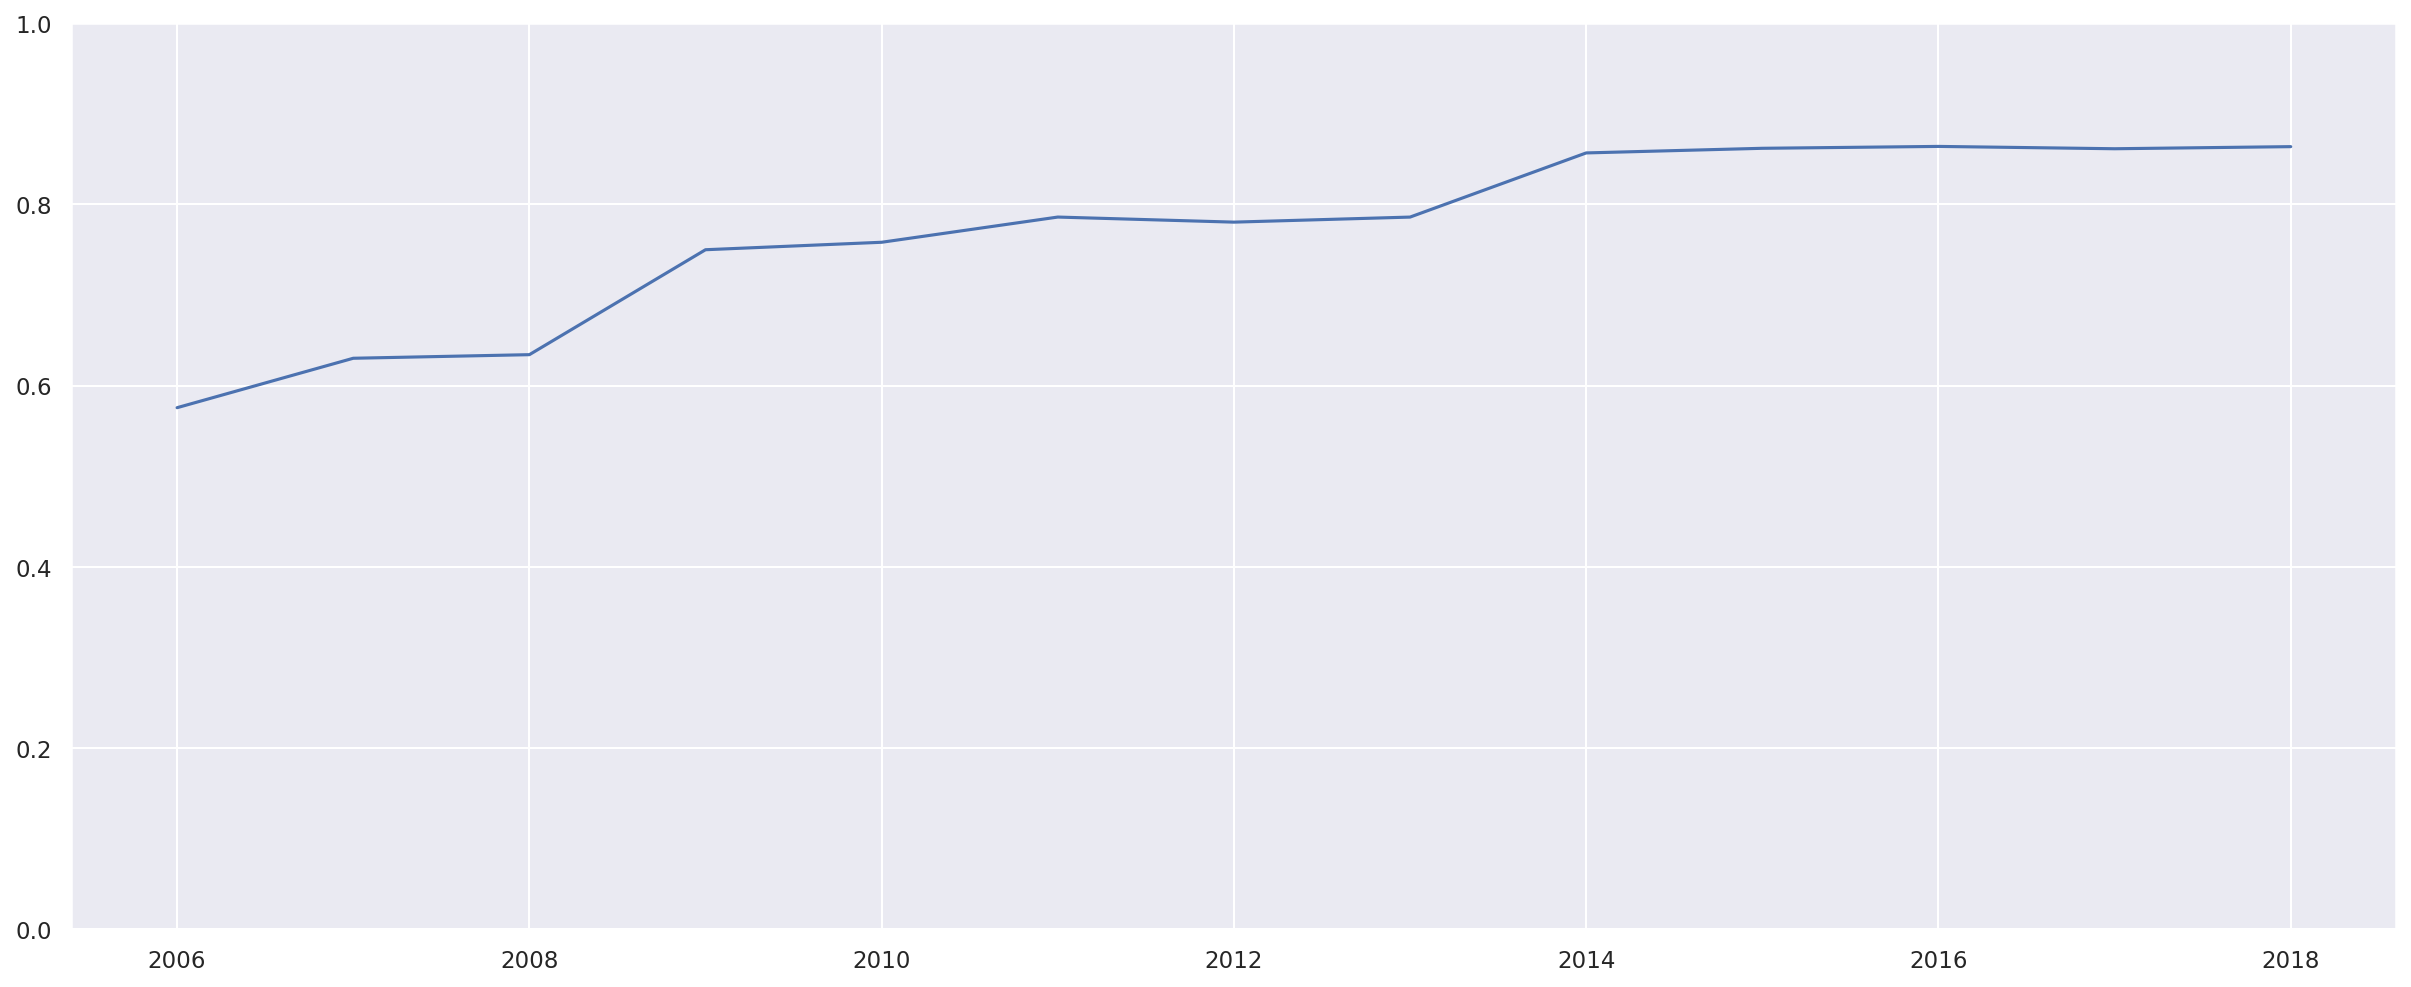

In [21]:
plt.plot(mapped_demand.report_year, mapped_demand.fraction_mapped)
plt.ylim(0, 1);

# Notes on irregularities and special cases
Unusual issues that need to be addressed, or demand discontinuities that may be useful in the context of aggregating historical demand into modern planning areas.
* Missing demand data / weird zeroes
  * 111: (2008)
  * 125: (2015)
  * 137: (2006)
  * 139: (2006) Only the last hour of every day. Maybe 0-23 vs 1-24 reporting?
  * 141: (2006, 2007, 2008, 2009, 2010)
  * 148: (2006)
  * 153: (2006)
  * 154: (2006)
  * 161: (all)
  * 183: (2007, 2009)
  * 208: (2008)
  * 273: (2007, 2008)
  * 283: (2007)
  * 287: (2008-2012)
  * 288: (2006)
  * 289: (2009)
  * 293: (2006)
  * 294: (2006)
  * 311: (2008-2011)
* Inverted Demand (Sign Errors):
  * 156: (2006, 2007, 2008, 2009)
  * 289: (2006-2008, 2010)
* Large demand discontinuities
  * 107: Demand triples at end of 2006.
  * 115: Two big step downs, 2007-2008, and 2011-2012
  * 121: 50% increase at end of 2007.
  * 128: Step up at end of 2007
  * 133: Step down end of 2013 and again end of 2015
  * 190: Demand doubled at end of 2008
  * 214: 50% jump in early 2012.
  * 256: big jump at end of 2006.
  * 261: Big jump at end of 2008.
  * 274: drop at end of 2007
  * 275: Jump at end of 2007
  * 287: Demand before and after big gap are very different.
  * 299: Big drop at end of 2015
  * 307: Jump at end of 2014
  * 321: Jump at end of 2013